In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,MaxPooling2D

Using TensorFlow backend.


# Методы нелинейной оптимизации
Работа будет состоять из дву частей:
1. Часть 1 - классические методы.
2. Часть 2 - методы оптимизации в глубоком обучении.

## Часть 1. Оптимизация функции Кобба-Дугласа тремя типами методов

Рассмотри задачу нелинейной регрессии на примере функции Кобба — Дугласа.
Функция Кобба — Дугласа — производственная функция (или функция полезности), отражающая зависимость объёма производства $Q$ от создающих его факторов производства — затрат труда $L$ и капитала $K$.

Впервые была предложена Кнутом Викселлем. В 1928 году функция проверена на статистических данных Чарльзом Коббом и Полом Дугласом в работе «Теория производства». В этой статье была предпринята попытка эмпирическим путём определить влияние затрачиваемого капитала и труда на объём выпускаемой продукции в обрабатывающей промышленности США.

Общий вид функции:

\begin{equation*}
Q(A,\alpha,\beta) = A\cdot L^\alpha \cdot K^\beta,
\end{equation*}
где $A$ — технологический коэффициент, $\alpha$ — коэффициент эластичности по труду, а $\beta$ — коэффициент эластичности по капиталу.



Предположим, наша задача - вычислить параматры $A,\alpha, \beta$ по имеющимся данным $Q, L, K$. Это типичная задача нелинейной регрессии. Для ее решения рассмотрим три типа методов:
1. Методы нулевого порядка - знание о произодных не нужно.
2. Методы первого порядка - знание о производной (градиенте) необходимо.
3. Методы второго порядка - необходимы знания о второй производной (матрицы Гессе)

В нашем случае рассмотрим следующие методы:
1. Метод нулевого порядка: метод Нелдера-Мида.


2. Методы первого порядка:

    2.1 Градиентный спуск    
    2.2 Метод нелинейного МНК
    
    
3. Метод Ньютона-Рафсона.

В качестве критерия оптимальности будем использовать все тот же квдаратичный критерий.

Для начала сгененируем данные самостоятельно (можно также воспользоваться реальными данными, но в данном случае это непринципиально). Пусть заранее известно, что $A=10, \alpha=0.5, \beta=1.5$

In [3]:
A_true = 10
alpha_true = 0.5
beta_true = 1.5
N = 100
L = np.random.rand(N) + 1
K = np.abs(np.random.randn(N))+1

def Q(A,alpha,beta):
    return A*(L**alpha)*(K**beta)
Q_true = Q(A_true,alpha_true,beta_true) # Без шума
Q_true_noise = Q_true + np.random.randn(N) # Шумом

В итоге ставится регрессионная задача:
$\frac{1}{N} \sum_{i=0}^{N} (A\cdot L_i^\alpha \cdot K_i^\beta - Q_i)^2 \rightarrow min$

In [4]:
def loss_(A,alpha,beta,Q_):
    return np.mean((Q(A,alpha,beta) - Q_)**2)

Все методы будут решать две задачи: поиск параметров при шуме и без. Таким образом, мы ожидаем максимально точной сходимости при отсуствии шума. Шум же возвращает нас к реальности 

### Метод нулевого порядка. Нелдер-Мид
Метод Нелдера-Мида является популярным методом нулевого порядка.
Метод является очень эффективным при негладких или сильно зашумленных функциях. Его эффективность высока особенно при количестве параметров не более 6. В нашем случае трех переменных этот метод должен показать свою эффективность. 

Основан на следующем алгоритме:

Задаются три коэффициента:
1. Коэффициент отражения $\alpha >0$, обычно выбирается равным 1.
2. Коэффициент сжатия $\beta >0$, обычно выбирается равным 0.5.
3. Коэффициент растяжения $\gamma >0$, обычно выбирается равным 2.

Далее непосредственно реализуем алгоритм Нелдера-Мид

In [5]:
def NM_min(Q_true,A_init = 8,alpha_init = 0,beta_init = 0,step_simpl = 1.5, iters = 100):
    al = 1#Коэффициент отражения
    be = 0.5# Коэффициент сжатия
    ga = 2#Коэффициент растяжения
    X0 = np.array([A_init,alpha_init,beta_init])
    
    # Шаг 1. Точки симплекса
    X1,X2,X3 = X0,X0,X0
    X1 = X1 + step_simpl * np.array([1,0,0])
    X2 = X2 + step_simpl * np.array([0,1,0])
    X3 = X3 + step_simpl * np.array([0,0,1])
    X = np.array([X0,X1,X2,X3])
    loss = []
      
    for i in range(iters):
        #Значение функции в точках симплекса
        F = np.array([loss_(X[0][0],X[0][1],X[0][2],Q_true),loss_(X[1][0],X[1][1],X[1][2],Q_true),
                      loss_(X[2][0],X[2][1],X[2][2],Q_true),loss_(X[3][0],X[3][1],X[3][2],Q_true)])

        # Шаг 2. Три точки
        
        isorted = np.argsort(F)
        h = isorted[-1]
        Xh = X[h]# Максимум
        Fh = F[h]
        
        g = isorted[-2]
        Xg = X[g]# Следующий после максимума
        Fg = F[g]

        l = isorted[0]
        Xl = X[l]# Минимум
        Fl = F[l]

        # Шаг 3. Центр тяжести
       
        Xc = np.zeros(3)
        for j in range(4):
            if j != h:
                Xc = Xc + X[j]
        Xc = 1/3 *Xc
          
        # Шаг 4. Отражение
        Xr = (1+al)*Xc - al*Xh
        Fr = loss_(Xr[0],Xr[1],Xr[2],Q_true)
        
        # Шаг 5. Что получилось?
        if Fr < Fl:
            Xe = (1-ga)*Xc + ga*Xr
            Fe = loss_(Xe[0],Xe[1],Xe[2],Q_true)
            if Fe < Fl:
                X[h] = Xe
                loss.append(loss_(Xl[0],Xl[1],Xl[2],Q_true))
                continue
            if Fl < Fe:
                X[h] = Xr
                loss.append(loss_(Xl[0],Xl[1],Xl[2],Q_true))
                continue
                
        if (Fl < Fr) and (Fr < Fg):
            X[h] = Xr
            loss.append(loss_(Xl[0],Xl[1],Xl[2],Q_true))
            continue
        if (Fl < Fr) and (Fr > Fg):
            pass
            
        if Fr > Fh:
            # Шаг 6. Сжатие
            Xs = be*Xh + (1-be)*Xc
            Fs = loss_(Xs[0],Xs[1],Xs[2],Q_true)
        if Fh > Fr:
            X[h] = Xr
            #Xr = Xh
            #Xh = X[h]
            Fh = Fr
            Fr = F[h]
            
            Xs = be*Xr + (1-be)*Xc
            Fs = loss_(Xs[0],Xs[1],Xs[2],Q_true)        
        
        if Fs < Fh:
            X[h] = Xs
            loss.append(loss_(Xl[0],Xl[1],Xl[2],Q_true))
            continue
        if Fs > Fh:
            for j in range(4):
                X[j] = Xl + (X[j] - Xl)/2
            loss.append(loss_(Xl[0],Xl[1],Xl[2],Q_true))        
    
    
    plt.plot(range(iters),loss,label=f"Лосс при Нелдера-Мида")
    plt.grid()
    plt.xlabel("Итерации")
    plt.ylabel("Лосс")
    plt.legend()
    plt.show()
    print(f"Коэффициенты при Нелдера-Мида. A = {Xl[0]:.{4}f}, alpha = {Xl[1]:.{4}f}, beta = {Xl[2]:.{4}f}")
    print(f"Конечный лосс при Нелдера-Мида: {loss_(Xl[0],Xl[1],Xl[2],Q_true)}")    

Результаты

Шума нет:


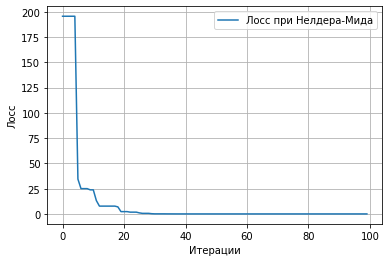

Коэффициенты при Нелдера-Мида. A = 10.0000, alpha = 0.5000, beta = 1.5000
Конечный лосс при Нелдера-Мида: 2.7255168294568585e-12

Шум есть:


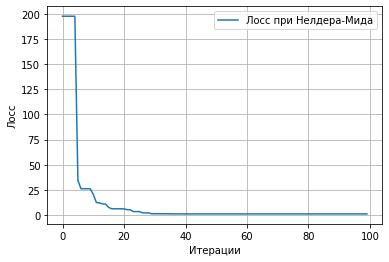

Коэффициенты при Нелдера-Мида. A = 9.8446, alpha = 0.5177, beta = 1.5085
Конечный лосс при Нелдера-Мида: 1.0321737813830685


In [6]:
print("Шума нет:")
NM_min(Q_true)
print("")
print("Шум есть:")
NM_min(Q_true_noise)

Как видно, алгоритм сошелся и это хорошо

### Методы первого порядка
#### Градиентый спуск
Градиентый спуск - один из основных базовых методов. Основан на свойстве градиента указвать в сторону наибольшего возрастания функциию Алгоритм гораздо проще, чем у предыдущего метода. Очередное приближение вычисляется через градиент в предудущей точке:


$\theta_{i+1} = \theta_{i} - \eta \nabla_\theta J( \theta_{i})$

Для инициализации нужна точка начального приближения и параметр $\eta$ - learning rate или скорость обучения.

In [9]:
# Метод градиентого спуска.

# Произвоная функции Кобба-Дугласа
def Q_grad(A,alpha,beta):
    return np.array([(L**alpha)*(K**beta),
                     np.log(L)*(L**alpha)*A*(K**beta),
                     np.log(K)*(K**beta)*A*(L**alpha)]).T

# Произвоная квадратичного критерия
def loss_grad(A,alpha,beta,Q_):
    return 2/N * Q_grad(A,alpha,beta).T.dot(Q(A,alpha,beta) - Q_)

# Градиентный спуск
def gradient_descent(Q_,A_init,alpha_init,beta_init,iters = 100,learning_rate = 0.01):
    A_d = A_init
    alpha_d = alpha_init
    beta_d = beta_init
    loss = []
   
    for i in range(iters):
        da_d = -learning_rate * loss_grad(A_d,alpha_d,beta_d,Q_)           
        A_d = A_d + da_d[0]
        alpha_d = alpha_d + da_d[1]
        beta_d = beta_d + da_d[2]        
        loss.append(loss_(A_d,alpha_d,beta_d,Q_))             
    
    plt.plot(range(iters),loss,label=f"Лосс при гр. спуске (learning_rate={learning_rate})")
    plt.grid()
    plt.xlabel("Итерации")
    plt.ylabel("Лосс")
    plt.legend()
    plt.show()
    print(f"Коэффициенты при гр. спуске. A = {A_d:.{4}f}, alpha = {alpha_d:.{4}f}, beta = {beta_d:.{4}f}")
    print(f"Конечный лосс при гр. спуске: {loss_(A_d,alpha_d,beta_d,Q_)}")
    print(f"Конечный градиент при гр. спуске:", loss_grad(A_d,alpha_d,beta_d,Q_))

Результаты:

Шума нет:


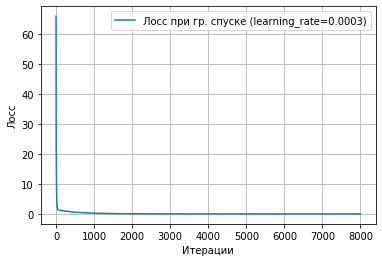

Коэффициенты при гр. спуске. A = 9.9984, alpha = 0.5001, beta = 1.5001
Конечный лосс при гр. спуске: 3.469395227848095e-06
Конечный градиент при гр. спуске: [-0.00424961  0.00034441  0.0002504 ]

Шум есть:


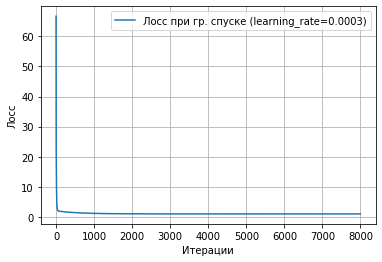

Коэффициенты при гр. спуске. A = 9.8434, alpha = 0.5178, beta = 1.5086
Конечный лосс при гр. спуске: 1.03217564068248
Конечный градиент при гр. спуске: [-0.00315305  0.00025838  0.00018847]


In [14]:
print("Шума нет:")
gradient_descent(Q_true,A_init = 9,alpha_init = 1,beta_init = 1,iters = 8000,learning_rate = 0.0003)
print("")
print("Шум есть:")
gradient_descent(Q_true_noise,A_init = 9,alpha_init = 1,beta_init = 1,iters = 8000,learning_rate = 0.0003)

В данном случае градиентный спуск работает тяжело, приходится долго подбирать параметры learning rate и начальное приближение. Количество итераций очень значительно.

#### Нелинейный МНК
Как известно, в случае линейной функции параметры МНК вычисляются как $\theta = (X^TX)^{-1}X^Ty$.
В нашем случае мы имеем нелинейную функцию $f(\theta)$. Идея метода нелинейного МНК в следующем: на каждой итерации функция $f(\theta)$ каждого i-того измерения раскладывается в ряд Тейлора до линейной части в точке $\theta_i$. И линейная часть используется в линейном МНК. Таким образом. получаем:
\begin{equation}
f_i(\theta) = f_i(\theta_i) + \nabla_\theta f_i( \theta_i)(\theta - \theta_i)
\end{equation}

Объедения градиенты каждого i-того измерения в матрицу $\nabla_\theta f$, получаем алгоритм обновления параметров:
\begin{equation}
\theta_{i+1} = \theta_{i} - (\nabla_\theta f^T\nabla_\theta f)^{-1}\nabla_\theta f^T(f( \theta_{i}) - f_{true})
\end{equation}

Реализуем:

In [15]:
def grad_mnk(A,alpha,beta,Q_):
    X_inv = np.linalg.inv(Q_grad(A,alpha,beta).T @ Q_grad(A,alpha,beta) + np.eye(3) * 1e-1)
    return X_inv @ Q_grad(A,alpha,beta).T @ (Q(A,alpha,beta) - Q_)

def nonLMNK(Q_,A_init,alpha_init,beta_init,iters):
        
    A_m = A_init
    alpha_m = alpha_init
    beta_m = beta_init
 
    loss_m = []
    for i in range(iters):
        da_m = -grad_mnk(A_m,alpha_m,beta_m,Q_)
               
        A_m = A_m + da_m[0]
        alpha_m = alpha_m + da_m[1]
        beta_m = beta_m + da_m[2]
        
        loss_m.append(loss_(A_m,alpha_m,beta_m,Q_))        
    
    plt.plot(range(iters),loss_m,label="Лосс при нелинейном МНК")
    plt.grid()
    plt.xlabel("Итерации")
    plt.ylabel("Лосс")
    plt.legend()
    plt.show()
    print(f"Коэффициенты при нелинейном МНК. A = {A_m:.{4}f}, alpha = {alpha_m:.{4}f}, beta = {beta_m:.{4}f}")
    print(f"Конечный лосс при нелинейном МНК: {loss_(A_m,alpha_m,beta_m,Q_)}")
    print(f"Конечный градиент при нелинейном МНК:", loss_grad(A_m,alpha_m,beta_m,Q_))

Шума нет:


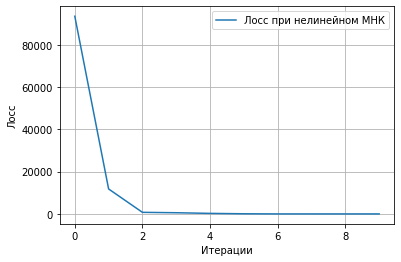

Коэффициенты при нелинейном МНК. A = 10.0000, alpha = 0.5000, beta = 1.5000
Конечный лосс при нелинейном МНК: 6.430504395695689e-17
Конечный градиент при нелинейном МНК: [-1.84757452e-08  3.36811363e-10 -4.49072478e-10]

Шум есть:


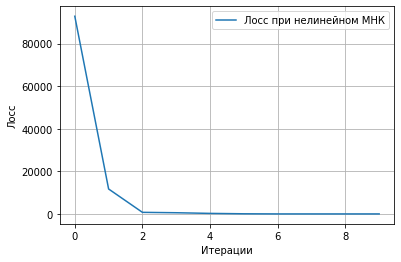

Коэффициенты при нелинейном МНК. A = 9.8446, alpha = 0.5177, beta = 1.5085
Конечный лосс при нелинейном МНК: 1.0321737813782947
Конечный градиент при нелинейном МНК: [-2.93625551e-08 -2.34243657e-08  1.43037362e-06]


In [17]:
print("Шума нет:")
nonLMNK(Q_true,A_init = 15,alpha_init = 4,beta_init = 4,iters = 10)
print("")
print("Шум есть:")
nonLMNK(Q_true_noise,A_init = 15,alpha_init = 4,beta_init = 4,iters = 10)

Как видно, этот метод при более плохих начальных условиях сходится значительно быстрее. Такая ситуация типична к градиентонму спуску и нелинейному МНК.

Отметим, что нелинейный МНК это обобщение градиентого спуска, где вместо одного числа learning rate фигурирует неотрицательно определенная матрица, которая вычисляется оптимально с точки зрения касательного пространства, именно поэтому он так хорошо (до определенного рода) может решать задачу оптимизации.

### Методы второго порядка. Метод Ньютона-Рафсона
Раскладывая оптимизируемую функцию до второго порядка и применяя метод Ньютона для поиска нулей, получаем метод Ньютона-Рафсона. Алгоритм обновления выглядит следующим образом:
\begin{equation}
\theta_{i+1} = \theta_{i} - H(\theta_{i})^{-1} \nabla_\theta J( \theta_{i})
\end{equation}
здесь $H(\theta_{i})$ - матрица Гессе.

Реализуем:

In [18]:
def Q_Hess(A,alpha,beta):
    return np.array([[np.zeros_like(L),np.log(L)*(L**alpha)*(K**beta),np.log(K)*(K**beta)*(L**alpha)],
          [np.log(L)*(L**alpha)*(K**beta),(np.log(L))**2*(L**alpha)*A*(K**beta),np.log(K)*np.log(L)*(K**beta)*A*(L**alpha)],
          [np.log(K)*(K**beta)*(L**alpha),np.log(K)*np.log(L)*(K**beta)*A*(L**alpha),np.log(K)**2*(K**beta)*A*(L**alpha)]]).T

def loss_Hess(A,alpha,beta,Q_):
    return 2/N * (Q_Hess(A,alpha,beta).T.dot(Q(A,alpha,beta) - Q_) + Q_grad(A,alpha,beta).T.dot(Q_grad(A,alpha,beta)))

In [19]:
def NR_min(Q_,A_init,alpha_init,beta_init,iters,LR = 0.1):
        
    A_m = A_init
    alpha_m = alpha_init
    beta_m = beta_init
 
    loss_m = []
    for i in range(iters):
        da_m = -1*np.linalg.inv(loss_Hess(A_m,alpha_m,beta_m,Q_) +  np.eye(3) * 1e-5) @ loss_grad(A_m,alpha_m,beta_m,Q_)
               
        A_m = A_m + da_m[0]
        alpha_m = alpha_m + da_m[1]
        beta_m = beta_m + da_m[2]
        
        loss_m.append(loss_(A_m,alpha_m,beta_m,Q_))        
    
    plt.plot(range(iters),loss_m,label="Лосс при нелинейном МНК")
    plt.grid()
    plt.xlabel("Итерации")
    plt.ylabel("Лосс")
    plt.legend()
    plt.show()
    print(f"Коэффициенты при методе Ньютона-Рафсона. A = {A_m:.{4}f}, alpha = {alpha_m:.{4}f}, beta = {beta_m:.{4}f}")
    print(f"Конечный лосс при методе Ньютона-Рафсона: {loss_(A_m,alpha_m,beta_m,Q_)}")
    print(f"Конечный градиент при методе Ньютона-Рафсона:", loss_grad(A_m,alpha_m,beta_m,Q_))

Шума нет:


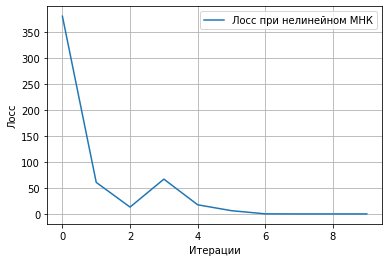

Коэффициенты при методе Ньютона-Рафсона. A = 10.0000, alpha = 0.5000, beta = 1.5000
Конечный лосс при методе Ньютона-Рафсона: 1.69700978918946e-18
Конечный градиент при методе Ньютона-Рафсона: [-6.01416440e-09 -1.37282682e-08 -3.49097399e-08]

Шум есть:


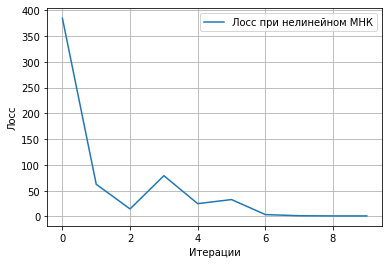

Коэффициенты при методе Ньютона-Рафсона. A = 9.8440, alpha = 0.5178, beta = 1.5086
Конечный лосс при методе Ньютона-Рафсона: 1.032174390614573
Конечный градиент при методе Ньютона-Рафсона: [-0.00409214 -0.0103641  -0.02628357]


In [21]:
print("Шума нет:")
NR_min(Q_true,A_init = 11,alpha_init = 1,beta_init = 1,iters = 10)
print("")
print("Шум есть:")
NR_min(Q_true_noise,A_init = 11,alpha_init = 1,beta_init = 1,iters = 10)

Метод Ньютона-Рафсона является мощным, но очень капризным. В нашем случае он довольно быстро сошелся к решению, однако при других начальных приближениях он ведет себя совершенно по-разному

## Часть 2. Два метода в глубом обучении

В глубоком обучении используются в основном разновидности градиентных спусков. Оно и понятно - вычислять матрицы вторых производных и тем более брать обратные матрицы при нескольких миллионах параметров сишком дорого. Поэтому часто используются следующие две разновидности градиентного спуска:
1. Метод Нестерова
2. Метод Адама
*Примечание*. Методов значительно больше, в том числе и тех, которые часто используются. Но многие из них имеют схожие идеи.

### Метод Нестерова.
Использует понятие импульса. Сама по себе идея методов с накоплением импульса до очевидности проста: «Если мы некоторое время движемся в определённом направлении, то, вероятно, нам следует туда двигаться некоторое время и в будущем». Для этого нужно уметь обращаться к недавней истории изменений каждого параметра. Можно хранить последние $n$ экземпляров $\Delta \theta$ и на каждом шаге по-честному считать среднее, но такой подход занимает слишком много памяти. К счастью, нам и не нужно точное среднее, а лишь оценку, поэтому воспользуемся экспоненциальным скользящим средним.

$v_t = \gamma v_{t-1} + \eta \nabla_\theta J( \theta)$

$\theta = \theta - v_t$

Чем меньше $\gamma$, тем больше алгоритм ведёт себя как обычный SGD.

Простое накопление импульса уже даёт хороший результат, но Нестеров идёт дальше и применяет хорошо известную в вычислительной математике идею: заглядывание вперёд по вектору обновления. Раз уж мы всё равно собираемся сместиться на $\gamma v_{t-1}$, то давайте посчитаем градиент функции потерь не в точке $\theta$, а в $\theta - \gamma v_{t-1}$. Отсюда:

$v_t = \gamma v_{t-1} + \eta \nabla_\theta J( \theta - \gamma v_{t-1} )$

$\theta = \theta - v_t$

Такое изменение позволяет быстрее «катиться», если в стороне, куда мы направляемся, производная увеличивается, и медленнее, если наоборот.

### Метод Адам.
**Adam** - adaptive moment estimation, ещё один оптимизационный алгоритм. Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$

От Нестерова Adam отличается тем, что мы накапливаем не $\Delta \theta$, а значения градиента, хотя это чисто косметическое изменение. Кроме того, мы хотим знать, как часто градиент изменяется. Авторы алгоритма предложили для этого оценивать среднюю нецентрированную дисперсию:

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$


Важный момент состоит в начальной калибровке $m_t$ и $v_t$: если задать нулевое начальное значение, то они будут долго накапливаться, особенно при большом окне накопления ($0 \ll \beta_1 < 1$, $0 \ll \beta_2 < 1$), а какие-то изначальные значения — это ещё два гиперпараметра. Никто не хочет ещё два гиперпараметра, так что мы искусственно увеличиваем $m_t$ и $v_t$ на первых шагах (примерно $0 < t < 10$ для $m_t$ и $0 < t < 1000$ для $v_t$)

$\hat{m}_t = \frac{m_t}{1 - \beta^t_1}$
$\hat{v}_t = \frac{v_t}{1 - \beta^t_2}$

В итоге, правило обновления:

$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \hat{m}_t$


В отличие от Части 1 мы не будем релизовывать руками эти методы, а воспользуемся библиотекой Keras

Мы решим типичную задачу обучения на MNIST - датасет рукописных цифр.

In [22]:
# Подготовка данных
def load_data(path='mnist.npz'):    
    with np.load(path, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)

(x_train,y_train),(x_test,y_test) = load_data()
batch_size, img_rows, img_cols = 64,28,28
x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,1)
x_test = x_test.reshape(x_test.shape[0],img_rows,img_cols,1)
input_shape = (img_rows,img_cols,1)
from keras.utils import np_utils
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)

In [23]:
# Глубокая сверточная сеть:
def model_CNN():

    model = Sequential()
    model.add(Conv2D(32,kernel_size=(5,5),padding='same',input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same"))

    model.add(Conv2D(64,kernel_size=(5,5),padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same"))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation("softmax"))
    return model

Обучение с Нестеровым

In [24]:
nesterov = keras.optimizers.SGD(learning_rate=0.01, momentum=0.1, nesterov=True)

In [25]:
model = model_CNN()
model.compile(loss='categorical_crossentropy',optimizer=nesterov,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.6502 - accuracy: 0.8039 - val_loss: 0.2076 - val_accuracy: 0.9391
Epoch 2/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1912 - accuracy: 0.9419 - val_loss: 0.1160 - val_accuracy: 0.9635
Epoch 3/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1328 - accuracy: 0.9597 - val_loss: 0.0946 - val_accuracy: 0.9691
Epoch 4/10
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1050 - accuracy: 0.9675 - val_loss: 0.0725 - val_accuracy: 0.9770
Epoch 5/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0889 - accuracy: 0.9733 - val_loss: 0.0592 - val_accuracy: 0.9807
Epoch 6/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0780 - accuracy: 0.9759 - val_loss: 0.0530 - val_accuracy: 0.9816
Epoch 7/10
60000/60000 [==============================] - 82s 1ms/st

Обучение Adam


In [26]:
model = model_CNN()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(x_train,y_train,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.1255 - accuracy: 0.9611 - val_loss: 0.0343 - val_accuracy: 0.9887
Epoch 2/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0272 - val_accuracy: 0.9900
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0310 - val_accuracy: 0.9905
Epoch 4/10
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.0215 - val_accuracy: 0.9933
Epoch 5/10
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0182 - accuracy: 0.9940 - val_loss: 0.0214 - val_accuracy: 0.9932
Epoch 6/10
60000/60000 [==============================] - 89s 1ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.0264 - val_accuracy: 0.9921
Epoch 7/10
60000/60000 [==============================] - 88s 1ms/st

Как видно, оба метода являются хорошими методами оптимизации (особенно для нашей скромной задачи)